In [ ]:
import fastai
import torch
from fastai.vision.all import *
from PIL import Image
import cv2
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation

fastai.__version__

defaults.device = torch.device('cuda') # makes sure the gpu is used

In [ ]:
dir(fastai.vision.models)

In [ ]:
path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')
path.ls()

(#2) [Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good'),Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/ng')]

In [ ]:
folders = ['good', 'ng']
files = []
for folder in folders:
    files += get_image_files(path/folder)

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=lambda x: files,
                   get_y=lambda o: o.parent.name,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandomResizedCrop(320), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=2.0,
                                               min_zoom=0.9,
                                               max_zoom=1.1,
                                               max_lighting=0.3,
                                               max_warp=0.2,
                                               p_affine=0.2,
                                               p_lighting=0.1),
                               Rotate(draw=5.0, p=0.9),
                               Dihedral(p=0.1),
                               RandomResizedCrop(320, min_scale=0.9),
                               Resize(224),
                               Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=16)


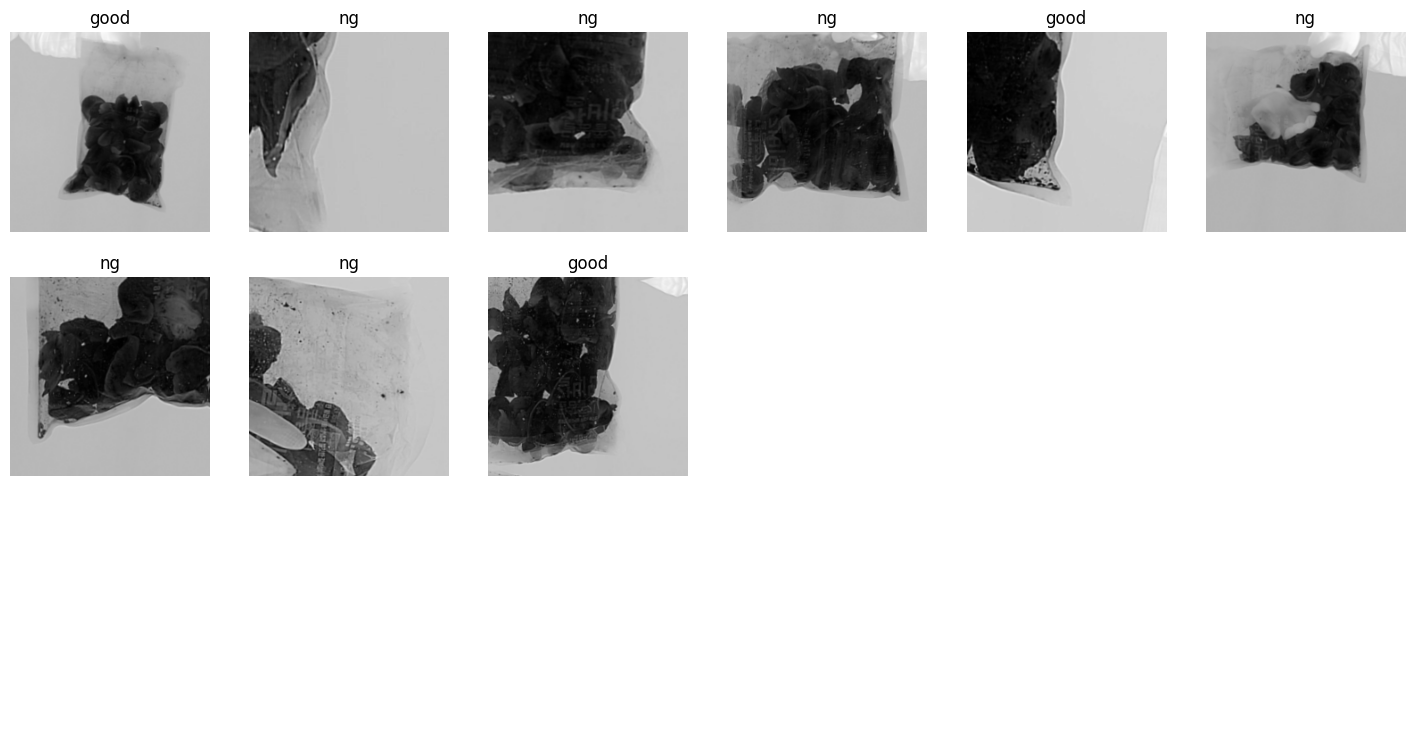

In [ ]:
dls.show_batch(nrows=3, ncols=6)

In [ ]:
print(dls.train_ds[0][0].shape)

(786, 982)


In [ ]:
# EarlyStoppingCallback 정의
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5)
# SaveModelCallback 정의
save_model = SaveModelCallback(monitor='valid_loss', fname='best_model')

learn = cnn_learner(dls, resnet34, metrics=[accuracy, F1Score(), Recall()], cbs=[early_stop, save_model])

learn.fine_tune(10)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,1.029465,1.160478,0.597561,0.611765,0.440678,01:16


Better model found at epoch 0 with valid_loss value: 1.1604777574539185.


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.648546,0.403143,0.841463,0.878505,0.796610,00:09
1,0.544860,0.078091,0.963415,0.973913,0.949153,00:11
2,0.437122,0.331778,0.890244,0.917431,0.847458,00:11
3,0.425203,0.193155,0.902439,0.927273,0.864407,00:08
4,0.427223,0.007936,1.000000,1.000000,1.000000,00:09
5,0.365698,0.068440,0.975610,0.982759,0.966102,00:09
6,0.332517,0.013757,1.000000,1.000000,1.000000,00:08
7,0.290481,0.003250,1.000000,1.000000,1.000000,00:09
8,0.270785,0.002755,1.000000,1.000000,1.000000,00:09
9,0.271231,0.003936,1.000000,1.000000,1.000000,00:08


Better model found at epoch 0 with valid_loss value: 0.40314343571662903.
Better model found at epoch 1 with valid_loss value: 0.07809130102396011.
Better model found at epoch 4 with valid_loss value: 0.007935801520943642.
Better model found at epoch 7 with valid_loss value: 0.0032496917992830276.
Better model found at epoch 8 with valid_loss value: 0.0027545669581741095.


In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

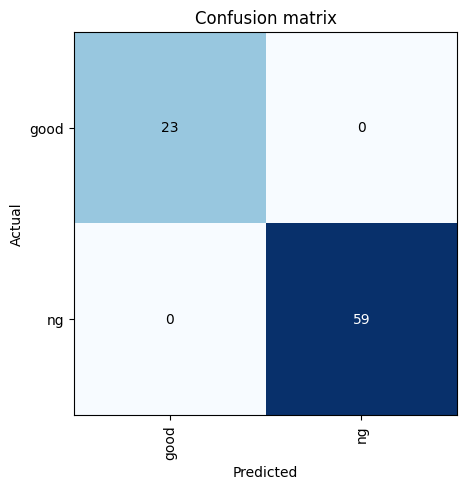

In [ ]:
interp.plot_confusion_matrix()

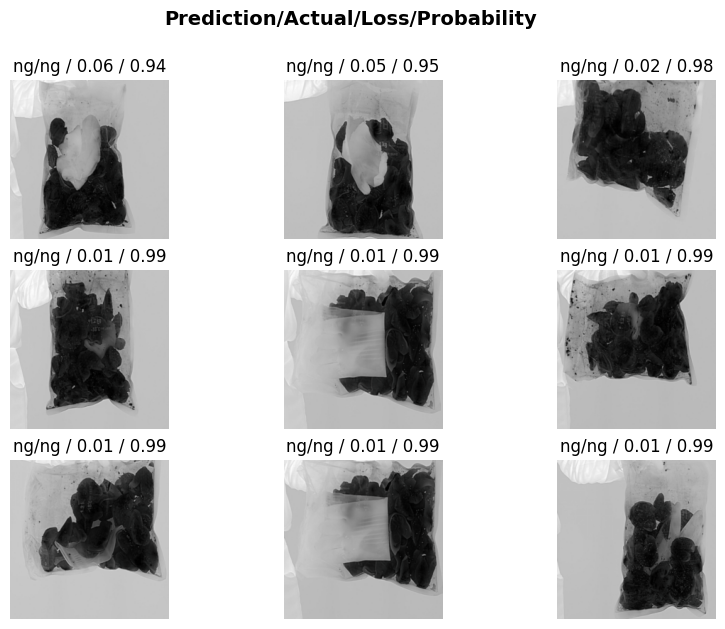

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [ ]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

Better model found at epoch 0 with valid_loss value: 1.0.
accuracy: 1.0
Recall: 1.0
F1 score: 1.0


# 학습데이터 csv 만들기

In [ ]:
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split

# 이미지 파일 경로와 라벨링 정보 추출
path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')
folders = ['good', 'ng']

file_list = []
label_list = []
for folder in folders:
    files = get_image_files(path/folder)
    file_list += files
    label_list += [folder] * len(files)

# train, test, valid로 분할
train_files, valid_files, train_labels, valid_labels = train_test_split(file_list, label_list, test_size=0.2, random_state=42)
train_files, test_files, train_labels, test_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=42)

# 데이터프레임 생성
train_df = pd.DataFrame({'path': train_files, 'label': train_labels})
test_df = pd.DataFrame({'path': test_files, 'label': test_labels})
valid_df = pd.DataFrame({'path': valid_files, 'label': valid_labels})

# 데이터프레임을 csv 파일로 저장
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/train.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/test.csv', index=False)
valid_df.to_csv('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/valid.csv', index=False)


# Mobilenet 사용시 cnn_leaner --> Learner 사용필수

In [ ]:
from torchvision.models import mobilenet_v2
mobilenetv2 = mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 람다 함수 대신 일반 함수 정의
def get_files(x):
    return files

def get_y(o):
    return o.parent.name

# 일반 함수를 사용하여 DataBlock 정의
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_files,
                   get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(224))


# EarlyStoppingCallback 정의
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5)
# SaveModelCallback 정의
save_model = SaveModelCallback(monitor='valid_loss', fname='best_model')

learn = Learner(dls, mobilenetv2, metrics=[accuracy, F1Score(average='macro'), Recall(average='macro')], cbs=[early_stop, save_model])

learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.466947,1.583819,0.719512,0.418440,0.500000,00:08


Better model found at epoch 0 with valid_loss value: 1.5838189125061035.


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.341762,0.297456,0.817073,0.804234,0.872881,00:09
1,0.287306,0.016545,1.000000,1.000000,1.000000,00:09
2,0.241338,0.025439,1.000000,1.000000,1.000000,00:07
3,0.292108,0.175143,0.902439,0.889562,0.932203,00:09
4,0.223585,0.048398,0.987805,0.985088,0.991525,00:09
5,0.218550,0.025792,1.000000,1.000000,1.000000,00:07
6,0.187775,0.046036,1.000000,1.000000,1.000000,00:09


Better model found at epoch 0 with valid_loss value: 0.2974563241004944.
Better model found at epoch 1 with valid_loss value: 0.016545312479138374.
No improvement since epoch 1: early stopping


In [ ]:
# 모델 저장
learn.export('colab_fastai_model_mobilenet.pkl')

PicklingError: ignored

In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

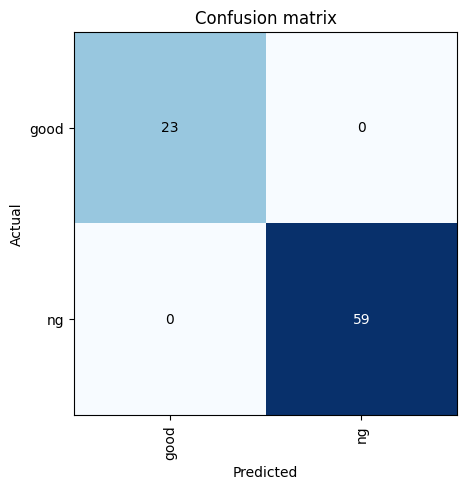

In [ ]:
interp.plot_confusion_matrix()

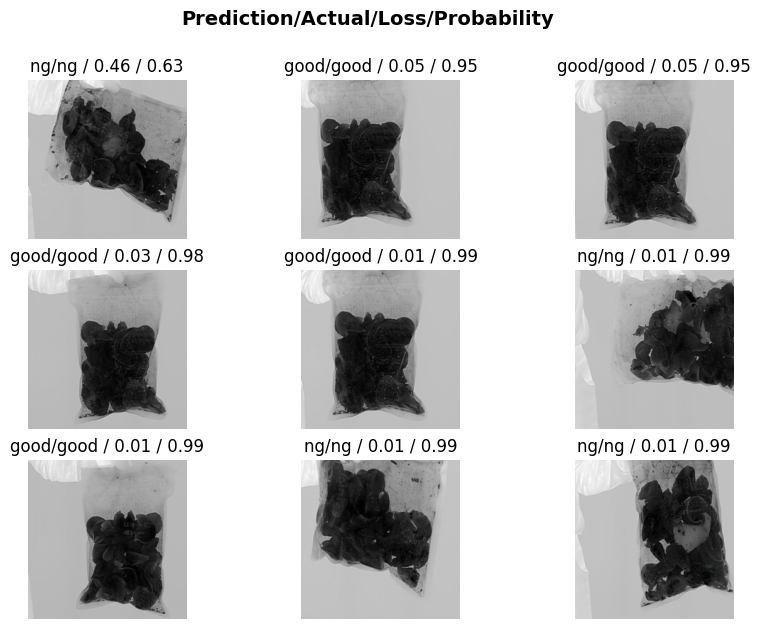

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

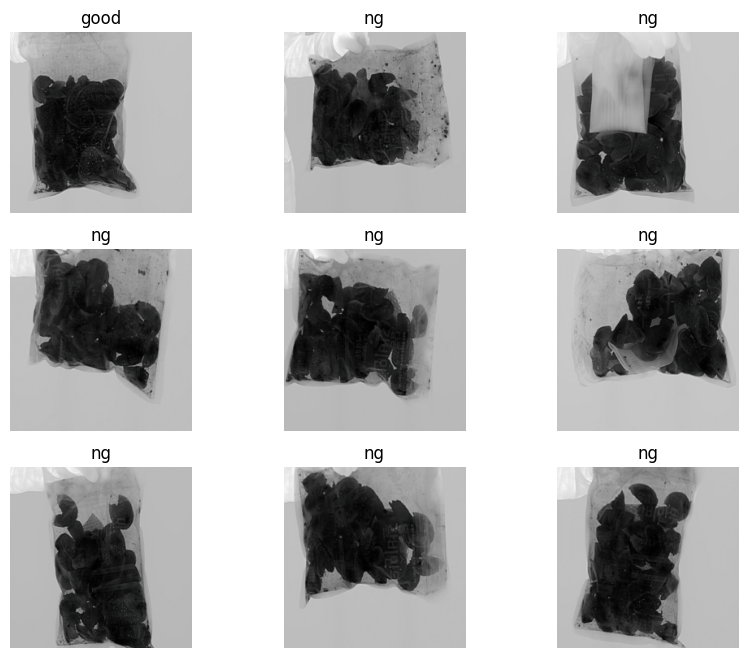

In [ ]:
dls.valid.show_batch(max_n=9, figsize=(10,8))

In [ ]:
learn.export('colab_fastai_model_mobilenet.pkl')

PicklingError: ignored

# mobilnetv2 + csv 파일

## resnet50

In [ ]:
from fastai.vision.all import *

path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
valid_df = pd.read_csv('valid.csv')

# 데이터 블록 정의
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_x=ColReader('path'),
                   get_y=ColReader('label'),
                   item_tfms=[RandomResizedCrop(320), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=2.0,
                                               min_zoom=0.9,
                                               max_zoom=1.1,
                                               max_lighting=0.3,
                                               max_warp=0.2,
                                               p_affine=0.2,
                                               p_lighting=0.1),
                               Rotate(draw=5.0, p=0.9),
                               Dihedral(p=0.1),
                               RandomResizedCrop(320, min_scale=0.9),
                               Resize(224),
                               Normalize.from_stats(*imagenet_stats),
                               FlipItem(),
                               RandomCrop(224),
                               Normalize.from_stats(*imagenet_stats)])


# 데이터셋 생성
dls = dblock.dataloaders(train_df, bs=8)

# 모델 생성 및 학습 설정
learn = cnn_learner(dls, resnet50, metrics=[accuracy, F1Score(), Recall()], pretrained=True)
learn.fine_tune(5, 3e-3)




/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pt

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,1.257793,6.967927,0.142857,0.062500,0.032258,00:04


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,1.011865,1.986908,0.485714,0.590909,0.419355,00:06
1,0.957250,2.643429,0.642857,0.747475,0.596774,00:05
2,0.673974,0.043546,0.985714,0.992000,1.000000,00:06
3,0.476895,0.028891,1.000000,1.000000,1.000000,00:06
4,0.368512,0.025621,1.000000,1.000000,1.000000,00:06


(#4) [None,None,None,None]

# mobilenet_v2

In [ ]:
from fastai.vision.all import *

path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
valid_df = pd.read_csv('valid.csv')

# 데이터 블록 정의
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_x=ColReader('path'),
    get_y=ColReader('label'),
    batch_tfms=[
        *aug_transforms(size=224,
                        max_rotate=2.0,
                        min_zoom=0.9,
                        max_zoom=1.1,
                        max_lighting=0.3,
                        max_warp=0.2,
                        p_affine=0.2,
                        p_lighting=0.1),
        Rotate(draw=5.0, p=0.9),
        Dihedral(p=0.1),
        RandomResizedCrop(224, min_scale=0.5),
        Normalize.from_stats(*imagenet_stats),
        FlipItem(),
        RandomCrop(224)
    ]
)



# 데이터셋 생성
dls = dblock.dataloaders(train_df, bs=8)

# 모델 생성 및 학습 설정
learn = Learner(dls, mobilenetv2, metrics=[accuracy, F1Score(), Recall()])
# learn.fine_tune(5, 3e-3)
learn.fine_tune(10)



epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.344214,0.720598,0.600000,0.708333,0.548387,00:04


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.301660,0.078316,0.985714,0.992000,1.000000,00:04
1,0.315919,0.251386,0.985714,0.991870,0.983871,00:04
2,0.322060,0.235429,1.000000,1.000000,1.000000,00:04
3,0.307457,0.104439,0.985714,0.991870,0.983871,00:05
4,0.328129,0.059518,0.971429,0.984127,1.000000,00:04
5,0.318131,0.052804,0.971429,0.984127,1.000000,00:04
6,0.272937,0.089995,0.985714,0.991870,0.983871,00:05
7,0.225802,0.092316,0.957143,0.975207,0.951613,00:04
8,0.238702,0.092159,0.942857,0.966667,0.935484,00:05
9,0.236532,0.068173,0.957143,0.975207,0.951613,00:05


In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

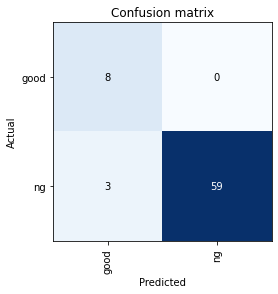

In [ ]:
interp.plot_confusion_matrix()

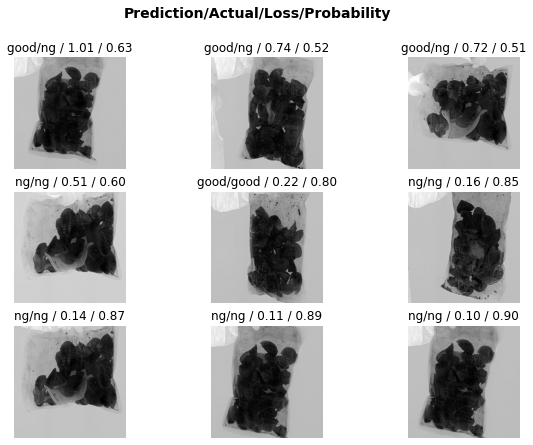

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [ ]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

accuracy: 0.9571428298950195
Recall: 0.9516129032258065
F1 score: 0.9752066115702479


# Ensemble
* resnet18
* mobilenet_v2

In [ ]:
from fastai.vision.all import *
from torchvision.models import mobilenet_v2
# from torchvision.models import mobilenet_v2
mobilenetv2 = mobilenet_v2(pretrained=True)


path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/test.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/valid.csv')

# 데이터 블록 정의
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_x=ColReader('path'),
    get_y=ColReader('label'),
    batch_tfms=[
        *aug_transforms(size=224,
                        max_rotate=2.0,
                        min_zoom=0.9,
                        max_zoom=1.1,
                        max_lighting=0.3,
                        max_warp=0.2,
                        p_affine=0.2,
                        p_lighting=0.1),
        Rotate(draw=5.0, p=0.9),
        Dihedral(p=0.1),
        RandomResizedCrop(224, min_scale=0.5),
        Normalize.from_stats(*imagenet_stats),
        FlipItem(),
        RandomCrop(224)
    ]
)



# 데이터셋 생성
dls = dblock.dataloaders(train_df, bs=8)




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn1 = Learner(dls, mobilenetv2, metrics=[accuracy, error_rate,F1Score(), Recall()])
learn2 = cnn_learner(dls, resnet18, metrics=[accuracy, error_rate,F1Score(), Recall()])

In [ ]:
# 두 모델의 예측값을 평균하여 앙상블 모델을 만듭니다.
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.cat(outputs, dim=1)

In [ ]:
ensemble_model = EnsembleModel([learn1.model, learn2.model])

In [ ]:
learn = Learner(dls, ensemble_model, metrics=[accuracy, error_rate,F1Score(), Recall()])

# 앙상블 모델을 미세 조정합니다.
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,recall_score,time
0,0.269124,3.644027,0.885714,0.114286,0.939394,1.000000,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,recall_score,time
0,0.776674,0.832664,0.757143,0.242857,0.841121,0.725806,00:06
1,0.350229,0.937318,0.585714,0.414286,0.694737,0.532258,00:05
2,0.205720,0.015610,1.000000,0.000000,1.000000,1.000000,00:05
3,0.126848,0.013229,1.000000,0.000000,1.000000,1.000000,00:05


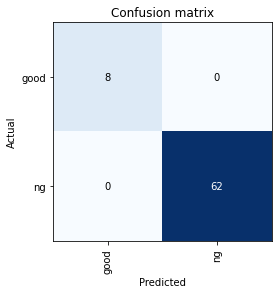

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

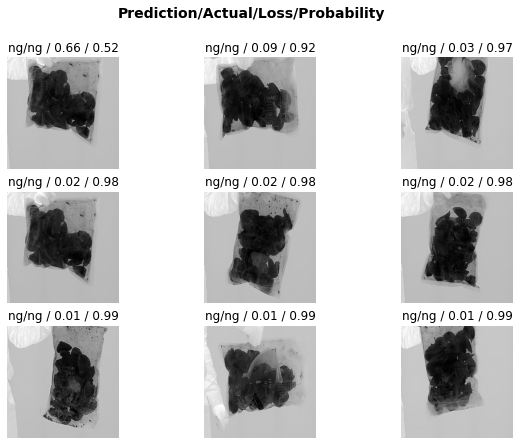

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [ ]:
# 검증 데이터셋으로 모델을 평가합니다.
test_dl = dls.test_dl
metrics = learn.validate(dl=test_dl)
print(f"검증 데이터셋에서의 평균 정확도: {metrics[0]:.4f}")

# 분류 결과를 시각화합니다.
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()


TypeError: ignored

In [ ]:
metrics

(#5) [0.013229007832705975,1.0,0.0,1.0,1.0]

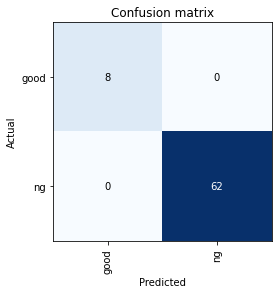

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Ensemble 코드 테스트

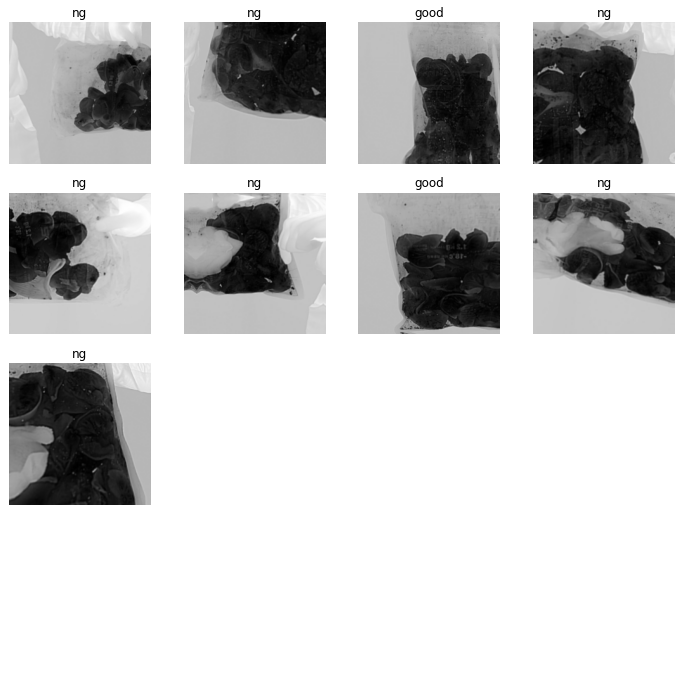

In [ ]:
import fastai
import torch
from fastai.vision.all import *
from PIL import Image
import cv2
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation

fastai.__version__

defaults.device = torch.device('cuda') # makes sure the gpu is used

path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')

folders = ['good', 'ng']
files = []
for folder in folders:
    files += get_image_files(path/folder)


dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=lambda x: files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandomResizedCrop(256), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=2.0,
                                               min_zoom=0.9,
                                               max_zoom=1.1,
                                               max_lighting=0.3,
                                               p_affine=0.9,
                                               p_lighting=0.1),
                               Rotate(draw=2.0, p=0.1),
                               Dihedral(p=0.1),
                               Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=16)
dls.show_batch(nrows=4, ncols=4)

In [ ]:
# Define the ResNet and MobileNet architectures
resnet = cnn_learner(dls, resnet50,metrics=[accuracy,F1Score(), Recall()])
mobilenet = cnn_learner(dls, mobilenet_v3_large,metrics=[accuracy,F1Score(), Recall()], pretrained=True)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` 

In [ ]:
# Train the ResNet and MobileNet models on the training set
resnet.fine_tune(3)
mobilenet.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,1.109565,1.658453,0.600000,0.671642,0.511364,00:07


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.890090,0.622658,0.809091,0.866242,0.772727,00:08
1,0.667185,0.181517,0.936364,0.958580,0.920455,00:07
2,0.577414,0.265538,0.936364,0.959064,0.931818,00:07


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,1.062939,0.137653,0.954545,0.971751,0.977273,00:05


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.828356,0.520703,0.781818,0.842105,0.727273,00:06
1,0.619105,0.642461,0.790909,0.851613,0.750000,00:05
2,0.551800,0.333187,0.863636,0.907975,0.840909,00:06


In [ ]:
# Use the trained models to predict the probabilities of each class on the validation set
resnet_probs,_ = resnet.get_preds(dl=dls.valid)
mobilenet_probs,_ = mobilenet.get_preds(dl=dls.valid)

# Combine the probabilities of both models using an averaging method
ensemble_probs = (resnet_probs + mobilenet_probs) / 2

# Get the final predictions by choosing the class with highest probability
ensemble_preds = torch.argmax(ensemble_probs, dim=1)

In [ ]:
ensemble_preds

TensorBase([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
            1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
            1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
            0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
            1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

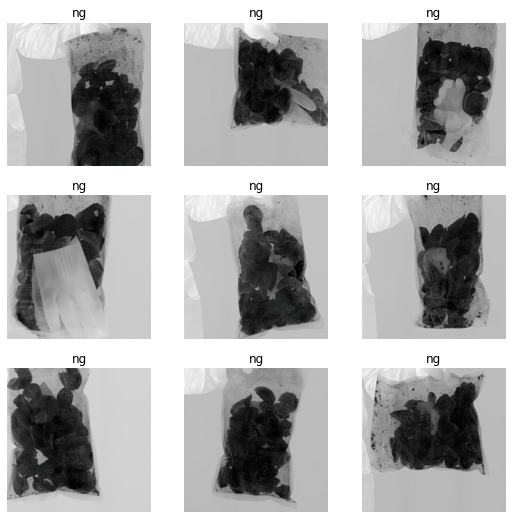

In [ ]:
dls.valid.show_batch()

In [ ]:
interp = ClassificationInterpretation(dls.valid, ensemble_probs, ensemble_preds)
interp.accuracy()

AttributeError: ignored

## 앙상블

In [ ]:
# Define the ResNet and MobileNet architectures
learn1 = cnn_learner(dls, resnet50,metrics=[accuracy,F1Score(), Recall()])
learn2 = Learner(dls, mobilenet_v3_large,metrics=[accuracy,F1Score(), Recall()])

In [ ]:
# 두 모델의 예측값을 평균하여 앙상블 모델을 만듭니다.
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.cat(outputs, dim=1)

ensemble_model = EnsembleModel([learn1.model, learn2.model])

TypeError: ignored

In [ ]:
learn = Learner(dls, ensemble_model, metrics=[accuracy,F1Score(), Recall()])

# 앙상블 모델을 미세 조정합니다.
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time


ValueError: ignored

In [ ]:
import fastai
import torch
from fastai.vision.all import *
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation

from torchvision.models import mobilenet_v2
mobilenetv2 = mobilenet_v2(pretrained=True)

fastai.__version__



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'2.7.11'

In [ ]:
def get_y(x):
    if x.parent.name == 'good':
        return 'good'
    elif x.parent.name == 'ng':
        return 'ng'
    else:
        raise ValueError('Unknown label')


# 데이터 경로 지정
path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')

# 데이터 로드
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandomResizedCrop(256), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=2.0,
                                               min_zoom=0.9,
                                               max_zoom=1.1,
                                               max_lighting=0.3,
                                               p_affine=0.9,
                                               p_lighting=0.1),
                               Rotate(draw=2.0, p=0.1),
                               Dihedral(p=0.1),
                               Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=16)

# Define the ResNet and MobileNet architectures
resnet = cnn_learner(dls, resnet18, metrics=[accuracy, F1Score(), Recall()])
mobilenet = Learner(dls, mobilenetv2, metrics=[accuracy, F1Score(), Recall()])

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
dls.vocab

['good', 'ng']

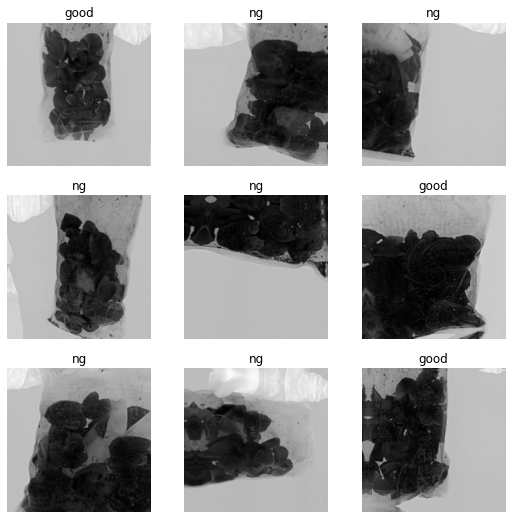

In [ ]:
dls.show_batch()

In [ ]:

# 두 모델의 예측값을 평균하여 앙상블 모델을 만듭니다.
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.cat(outputs, dim=1)

ensemble_model = EnsembleModel([resnet.model, mobilenet.model])

learn = Learner(dls, ensemble_model, metrics=[accuracy, F1Score(), Recall(), error_rate])

# 앙상블 모델을 미세 조정합니다.
learn.fine_tune(10)


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,error_rate,time
0,0.376217,0.161206,0.963636,0.976744,0.954545,0.036364,00:06


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,error_rate,time
0,0.295595,0.109119,0.963636,0.976744,0.954545,0.036364,00:07
1,0.273948,0.065529,0.981818,0.988506,0.977273,0.018182,00:06
2,0.246280,0.017204,1.000000,1.000000,1.000000,0.000000,00:06
3,0.251857,0.029962,1.000000,1.000000,1.000000,0.000000,00:06
4,0.256453,0.039642,0.981818,0.988506,0.977273,0.018182,00:06
5,0.262710,0.086785,0.972727,0.982659,0.965909,0.027273,00:06
6,0.260410,0.082826,0.954545,0.971098,0.954545,0.045455,00:07
7,0.234434,0.084638,0.954545,0.970760,0.943182,0.045455,00:06
8,0.216288,0.084882,0.963636,0.976744,0.954545,0.036364,00:06
9,0.184081,0.051503,1.000000,1.000000,1.000000,0.000000,00:06


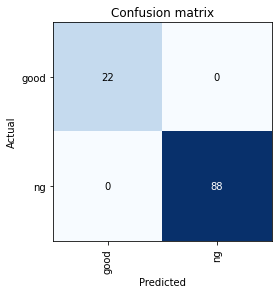

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

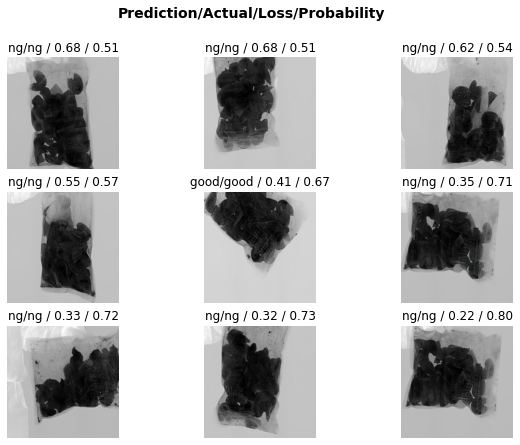

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [ ]:
preds,_ = learn.get_preds(dl=dls.valid)
pred_classes = preds.argmax(dim=1)


In [ ]:
interp = ClassificationInterpretation(dls.valid, preds, pred_classes)
interp.plot_confusion_matrix()
interp.print_classification_report()


AttributeError: ignored

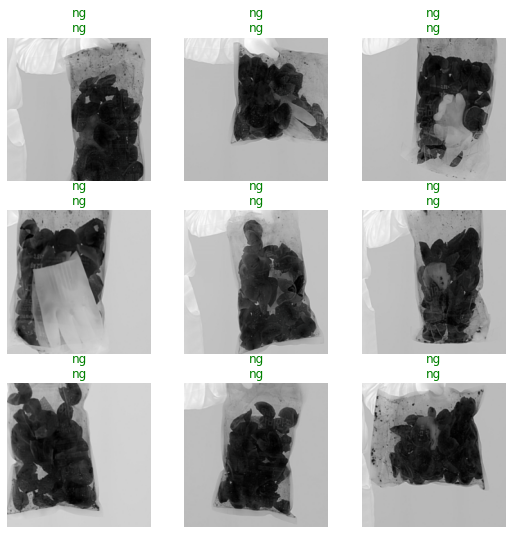

In [ ]:
b = dls.valid.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)
dls.valid.show_results(b, preds)

# mobilenet_v3

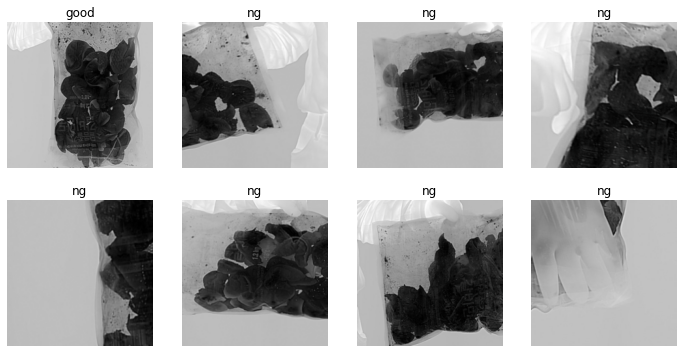

In [ ]:
import fastai
import torch
from fastai.vision.all import *
from PIL import Image
import cv2
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation

fastai.__version__

defaults.device = torch.device('cuda') # makes sure the gpu is used

path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')

folders = ['good', 'ng']
files = []
for folder in folders:
    files += get_image_files(path/folder)


dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=lambda x: files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandomResizedCrop(460), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=2.0,
                                               min_zoom=0.9,
                                               max_zoom=1.1,
                                               max_lighting=0.2,
                                               p_affine=0.1,
                                               p_lighting=0.1),
                               Rotate(draw=2.0, p=0.1),
                               Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=8)
dls.show_batch()

In [ ]:
from torchvision.models import mobilenetv2
mobile = mobilenet_v2(pretrained=True)

learn = Learner(dls, mobile, metrics=[accuracy, F1Score(), Precision(), Recall()])

learn.fine_tune(10)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,3.027287,1.481616,0.759036,0.861111,0.756098,1.000000,00:33


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.401207,0.023294,1.000000,1.000000,1.000000,1.000000,00:05
1,0.339743,0.734412,0.638554,0.680851,1.000000,0.516129,00:06
2,0.425637,0.526821,0.759036,0.807692,1.000000,0.677419,00:06
3,0.390558,0.601589,0.771084,0.867133,0.765432,1.000000,00:06
4,0.351542,0.671664,0.650602,0.694737,1.000000,0.532258,00:06
5,0.340269,0.107535,0.963855,0.976378,0.953846,1.000000,00:06
6,0.267164,0.008342,1.000000,1.000000,1.000000,1.000000,00:05
7,0.198495,0.005446,1.000000,1.000000,1.000000,1.000000,00:05
8,0.193760,0.014025,1.000000,1.000000,1.000000,1.000000,00:06
9,0.158766,0.008741,1.000000,1.000000,1.000000,1.000000,00:05


# resnet, mobilenet_v2

In [ ]:
from fastai.vision.all import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img'


In [ ]:
data = []
labels = []

for root, dirs, files in os.walk(dir_path):
    for file in files:
        if file.endswith('jpg') or file.endswith('.png'):
            data.append(os.path.join(root, file))
            labels.append('good' if 'good' in root else 'ng')

df = pd.DataFrame({'path': data, 'label': labels})

In [ ]:
df.head()

,path,label
0,/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good/Snap-0105.jpg,good
1,/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good/Snap-0113.jpg,good
2,/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good/Snap-0106.jpg,good
3,/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good/Snap-0119.jpg,good
4,/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good/Snap-0118.jpg,good


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_x=ColReader('path'),
    get_y=ColReader('label'),
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = dblock.dataloaders(df)

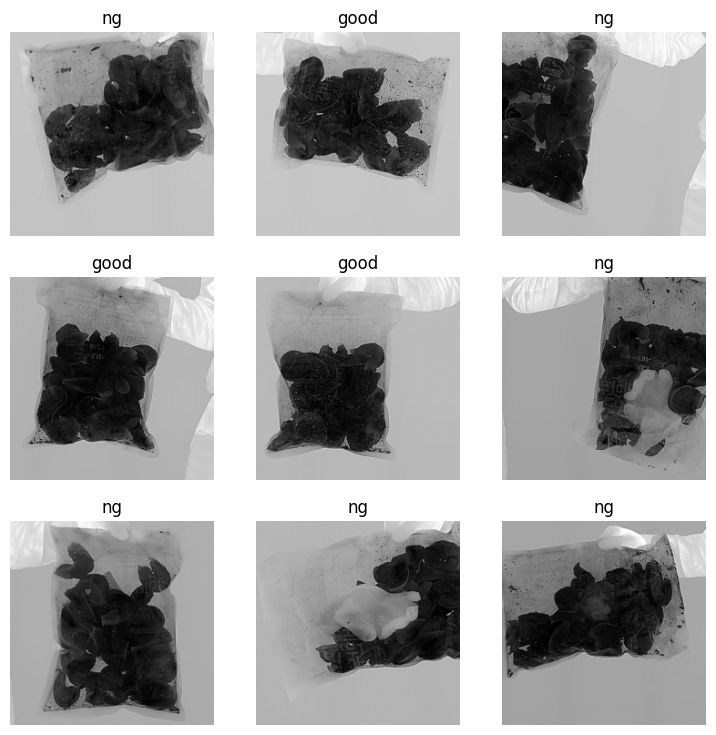

In [ ]:
dls.show_batch()

# Mandoo horizonta

In [53]:
import fastai
import torch
from fastai.vision.all import *
from fastai.vision import *
from PIL import Image
import cv2
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation


from torchvision.models import inception_v3
from torchvision.models import inception_resnet_v2



fastai.__version__

defaults.device = torch.device('cuda') # makes sure the gpu is used

ImportError: ignored

In [2]:
dir(fastai.vision.models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [2]:
path = Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train')
path.ls()

(#3) [Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/ng'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/.ipynb_checkpoints')]

In [3]:
folders = ['good', 'ng']
files = []
for folder in folders:
    files += get_image_files(path/folder)

In [4]:
files[:10]

(#10) [Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145037611.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145353612.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145411795.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145512015.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145115071.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145547694.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145317792.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/data

In [36]:
#이미지 전처리
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=lambda x: files,
                   get_y=lambda o: o.parent.name,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=2.0,
                                               min_zoom=0.9,
                                               max_zoom=1.1,
                                               max_lighting=0.3,
                                               max_warp=0.2,
                                               p_affine=0.2,
                                               p_lighting=0.1),
                               Rotate(draw=5.0, p=0.9),
                               Dihedral(p=0.1),
                               RandomResizedCrop(320, min_scale=0.9),
                               Resize(224),
                               Normalize.from_stats(*imagenet_stats)])


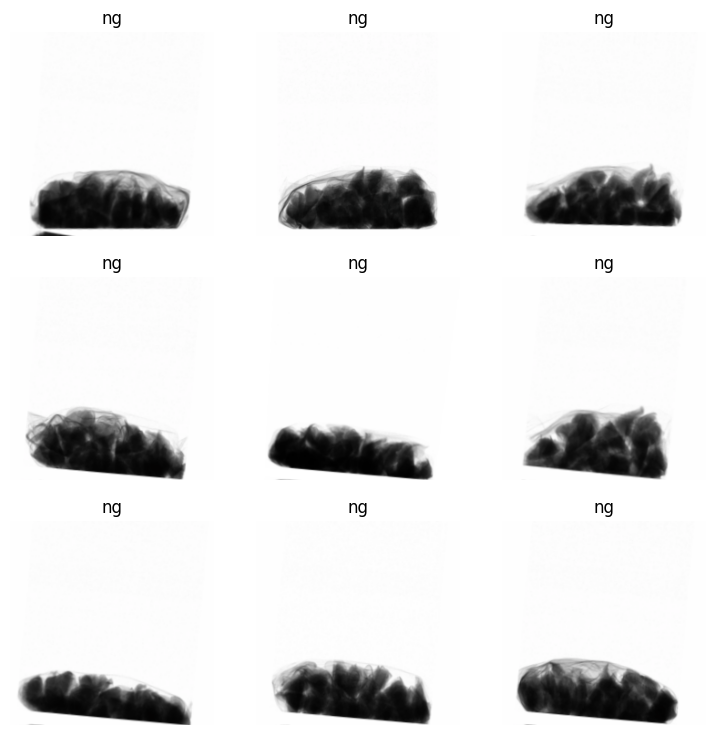

In [37]:
dls = dblock.dataloaders(path, bs=16)
dls.show_batch(nrows=3, ncols=3)


In [32]:
print(dls.train_ds[0][0].shape)

(1024, 1024)


In [54]:
# EarlyStoppingCallback 정의
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5)
# SaveModelCallback 정의
save_model = SaveModelCallback(monitor='valid_loss', fname='best_model')

# learn = cnn_learner(dls, resnet34, metrics=[accuracy, F1Score(), Recall()], cbs=[early_stop, save_model])
# learn = vision_learner(dls, resnet34, metrics=[accuracy, F1Score(), Recall()], cbs=[early_stop, save_model])
# learn = cnn_learner(dls, model, metrics=[accuracy, F1Score(), Recall()])
# model = inception_v3(pretrained=True)
learn = cnn_learner(dls, densenet121, metrics=[accuracy, F1Score(), Recall()])



/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet

SuggestedLRs(valley=0.013182567432522774)

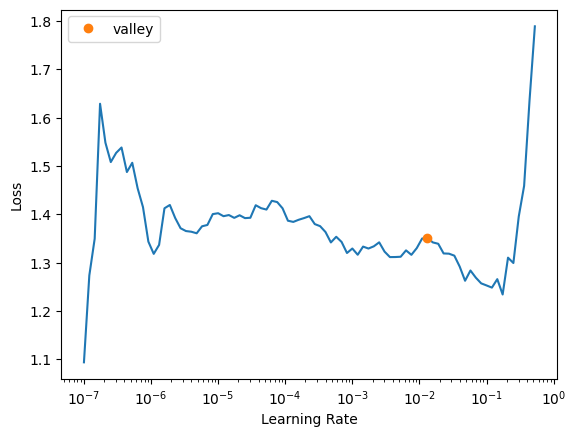

In [55]:
# Unfreeze all layers of the CNN
learn.unfreeze()

# Find the optimal learning rate the plot a visual
# Explore lr from start_lr to end_lr over num_it iterations in learn
learn.lr_find()

In [56]:
# learn.lr_find()에서 제안한 학습률을 사용
suggested_lr = 0.012

# fine_tune 메서드에 학습률 적용
learn.fine_tune(10, base_lr=suggested_lr)


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.834111,0.354426,0.885246,0.936937,0.962963,00:09


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.349975,0.172019,0.928962,0.960486,0.975309,00:09
1,0.298655,0.329576,0.901639,0.946746,0.987654,00:09
2,0.300895,0.091347,0.967213,0.981366,0.975309,00:09
3,0.267758,0.136355,0.967213,0.981250,0.969136,00:09
4,0.219761,0.059608,0.989071,0.993865,1.000000,00:09
5,0.246135,0.096359,0.967213,0.981366,0.975309,00:10
6,0.205480,0.039752,0.983607,0.990654,0.981481,00:09
7,0.151942,0.028923,0.983607,0.990712,0.987654,00:09
8,0.100539,0.030099,0.989071,0.993865,1.000000,00:09
9,0.083868,0.032308,0.983607,0.990826,1.000000,00:09


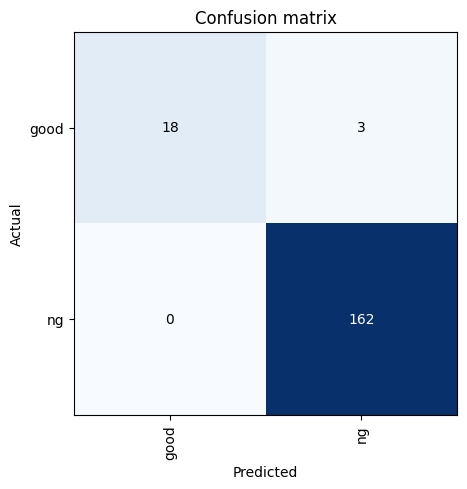

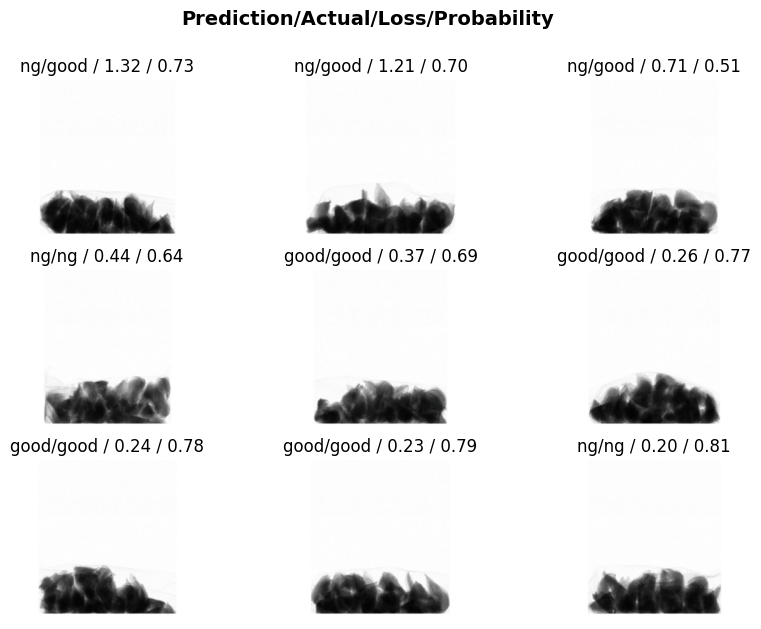

In [57]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

interp.plot_confusion_matrix()

# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [43]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

accuracy: 0.9562841653823853
Recall: 0.9506172839506173
F1 score: 0.9746835443037974
